In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter

In [3]:
target = 'AU Mic'
lcf = lightkurve.search_lightcurvefile(target).download(quality_bitmask='hard',)
lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()

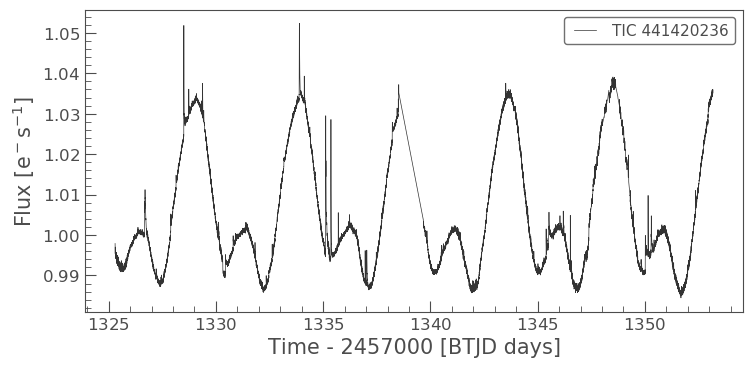

In [4]:
lc_hdr = lcf.header(ext=1)
lc.plot(normalize=False)

In [5]:
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lc.time.min() + lc.time.max())
flux = (lc.flux - 1.0) * 1e3
time = lc.time
flux_err = lc.flux_err
m = np.isfinite(time) & np.isfinite(flux)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

In [19]:
# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(20):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 501, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = resid < sigma*1.
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

(1347, 1349)

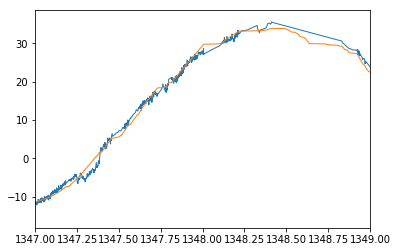

In [22]:
plt.plot(time[m], flux[m], lw=1)
plt.plot(time, smooth, lw=1)
plt.xlim(1330+17,1332+17)

In [23]:
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

x = time
y = flux
yerr = flux_err

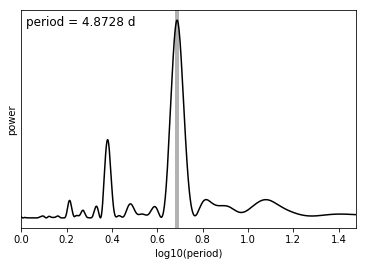

In [24]:
results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [25]:
def build_model(mask=None, start=None):
    guess_p_period = 16.93
    guess_p_t0 = -8.84
    guess_p_depth = 0.04
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=5.0)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.4, 0.2]))
        R_star = 0.83, 0.1
        Rho_star = 0.9
        r_star = pm.Bound(pm.Normal, lower=0.0, upper=10.)("logror", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=1)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(guess_p_period), sd=0.2, 
                         testval=np.log(guess_p_period))
        t0 = pm.Normal("t0", mu=guess_p_t0, sd=0.2, testval=guess_p_t0)
        
        logror = pm.Bound(pm.Normal, lower=np.log(0.01), upper=np.log(0.3))("logror", 
                                                                            mu=np.log(guess_p_depth),
                                                                            sd=2)
        ror = pm.Deterministic("ror", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=0.8, testval=0.2)
        b = pm.Deterministic("b", b_param * (1 + ror))
        
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.7)("ecc", alpha=0.867, beta=3.03, testval=0.1)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.1,0.05], shape=2)
        omega = xo.distributions.Angle("omega")
        
#         ecc= [0., 0.]
#         omega = [0, 0]

        
#         pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
#         pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))  
#         pm.Potential("ror_prior", -tt.log(ror))

    #         pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[mean, logs2])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param, logP, t0])
    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidime

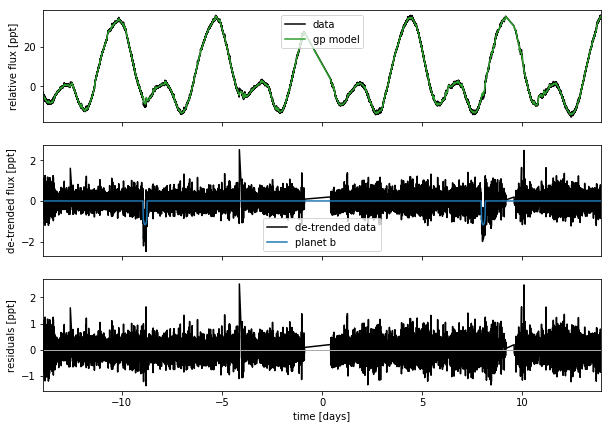

In [27]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b"]):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

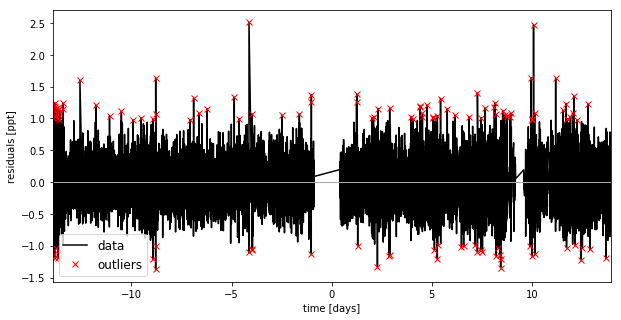

In [28]:
mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -7,131.5, ||grad|| = 729.46: 100%|██████████| 7/7 [00:00<00:00, 35.08it/s]   
logp = -7,087.7, ||grad|| = 1.1671: 100%|██████████| 14/14 [00:00<00:00, 27.86it/s]  
logp = -7,086.8, ||grad|| = 0.014887: 100%|██████████| 19/19 [00:00<00:00, 31.38it/s]  
logp = -7,086.1, ||grad|| = 5.8735e-05: 100%|██████████| 12/12 [00:00<00:00, 47.90it/s]  
logp = -7,086, ||grad|| = 1.6207: 100%|██████████| 15/15 [00:00<00:00, 28.07it/s]   
logp = -7,085.4, ||grad|| = 7,666.5: 100%|██████████| 21/21 [00:00<00:00, 39.68it/s]  


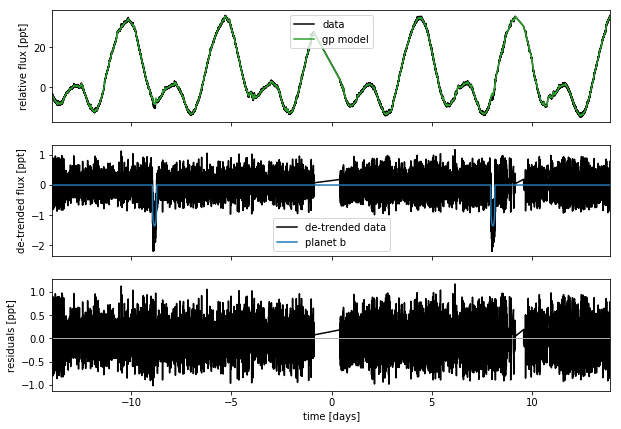

In [29]:
model, map_soln = build_model(mask, map_soln0)
fig = plot_light_curve(model, map_soln, mask)
fig.savefig('gp-map-aumic.png', dpi=200)

In [30]:
sampler = xo.PyMC3Sampler(window=100, start=200, finish=200)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln, step_kwargs=dict(target_accept=0.9))

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 208/208 [07:18<00:00,  2.73s/draws]


In [31]:
with model:
#     db = pm.backends.Text('aumic-trace')
    trace = sampler.sample(draws=500)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
Sampling 4 chains: 100%|██████████| 2000/2000 [04:50<00:00,  2.49draws/s]
There were 431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.003086753383566469, but should be close to 0.9. Try to increase the number of tuning steps.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.018469167310477215, but should be close to 0.9. Try to increase the number of tuning steps.
There were 272 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.006096234592628775, but should be close to 0.9. Try to increase the number of tuning steps.
There were 331 divergenc

In [33]:
pm.summary(trace, varnames= ['b_param', 'logror', 't0', 'logP', 'ecc', 'omega',
           'logrho_star', 'r_star', 'u_star', 'mix', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS',
                             'logs2', 'mean'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_param,0.310216,0.116019,0.011546,0.130837,0.484523,2.458740,2.609604
logror,-2.961791,0.020941,0.002085,-3.010134,-2.930507,8.529370,1.201497
t0,-8.853165,0.001404,0.000140,-8.854791,-8.850827,2.021103,11.839542
logP,2.829079,0.000041,0.000004,2.829033,2.829163,2.712434,2.373483
ecc,0.400994,0.284989,0.028475,0.079073,0.866964,2.047941,7.433573
omega,1.110142,0.883683,0.088166,0.270037,2.710257,2.131848,4.690680
logrho_star,0.162534,1.014976,0.101441,-1.611162,1.281048,2.028936,10.076543
r_star,0.774271,0.073236,0.007302,0.635986,0.880719,2.556610,2.500036
u_star__0,0.342195,0.195703,0.019515,0.021878,0.624917,3.112833,2.018941
u_star__1,0.013864,0.258433,0.025791,-0.283690,0.433714,2.583518,2.557400


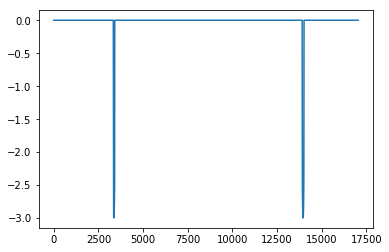

In [34]:
plt.plot([x for x in xo.get_samples_from_trace(trace)][0]['light_curve'])

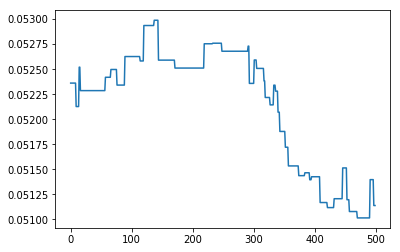

In [56]:
plt.plot(trace.get_values('ror', chains=[3]))

In [36]:
map_soln

{'mean': array(6.43508692),
 'logs2': array(-2.28766865),
 'logS': array(-6.27480301),
 'logw': array(4.47253604),
 'logamp': array(5.00473086),
 'logperiod': array(1.5836599),
 'logQ0': array(0.93244485),
 'logdeltaQ': array(8.53676907),
 'mix_interval__': array(-1.1134877),
 'u_star_quadlimbdark__': array([-0.57536414, -0.69314718]),
 'r_star': array(0.83),
 'logrho_star': array(-0.10536052),
 'logP': array(2.82687251),
 't0': array(-8.84109684),
 'logror_interval__': array(-0.58863152),
 'b_param_interval__': array(-1.84154089),
 'ecc_interval__': array(-2.19722458),
 'omega_angle__': array([0., 1.]),
 'period': array(4.87275704),
 'mix': array(0.24722125),
 'u_star': array([0.4, 0.2]),
 'rho_star': array(0.9),
 'logror': array(-3.3911165),
 'ror': array(0.03367106),
 'b_param': array(0.13686916),
 'b': array(0.14147769),
 'ecc': array(0.1),
 'omega': array(1.57079633),
 'p_period': array(16.89254692),
 'r_pl': array(0.02794698),
 'r_ple': array(3.05264683),
 'light_curve': array([0

In [88]:
np.sqrt(0.0005)

0.022360679774997897

In [37]:
map_soln0

{'mean': array(6.52065799),
 'logs2': array(-2.19231288),
 'logS': array(-6.37367386),
 'logw': array(4.50815601),
 'logamp': array(5.0183306),
 'logperiod': array(1.58381374),
 'logQ0': array(0.65105214),
 'logdeltaQ': array(8.48101569),
 'mix_interval__': array(-1.14466942),
 'u_star_quadlimbdark__': array([-0.57536414, -0.69314718]),
 'r_star': array(0.83),
 'logrho_star': array(-0.10536052),
 'logP': array([3.13272728, 3.34364473]),
 't0': array([-8.89822209,  2.98466525]),
 'logror_interval__': array([-0.53122343, -1.03481048]),
 'b_param_interval__': array([-1.43965214, -0.75880109]),
 'ecc_interval__': array([-2.19722458, -2.19722458]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.87350672),
 'mix': array(0.24146408),
 'u_star': array([0.4, 0.2]),
 'rho_star': array(0.9),
 'logror': array([-3.34593948, -3.7135376 ]),
 'ror': array([0.0352271 , 0.02439108]),
 'b_param': array([0.19159922, 0.31890662]),
 'b': array([0.19834871, 0.3266851 ]),
 'ecc': ar